# Introduction to Deep Learning - Final Project

Peer-graded Assignment: Intel Image Classification based on CNN

## 0. Introduction

This notebook contains the final project of the course Introduction to Deep Learning. In this notebook, the CNN model is used for classifying photos of six different categories, inlcuding mountains, streets, glaciers, buildings, sea, and forests. The dataset can be found on Kaggle ("https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras").

The notebook contains the following parts:

1. Exploratory data analysis

2. Applying the CNN algorithm

3. Conclusions

## 1. EDA 

### 1.1 Loading data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from matplotlib.lines import Line2D

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Define relative dataset paths
datasets = ['../input/seg_train/seg_train', '../input/seg_test/seg_test']

In [3]:
# Class names and label mapping
class_names = sorted(os.listdir(datasets[0]))
class_names_label = {class_name: idx for idx, class_name in enumerate(class_names)}
print(f"Class to Label Mapping: {class_names_label}")

Class to Label Mapping: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [4]:
# This is a helper function for loading the data.
IMAGE_SIZE = (96, 96)

def load_data():
    output = []
    
    for dataset in datasets:
        images = []
        labels = []
        
        print(f"Loading {dataset}")
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(dataset, folder, file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                images.append(image)
                labels.append(label)
        
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
    
    return output

# Load the data
(train_images, train_labels), (test_images, test_labels) = load_data()

# Shuffle training set
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Normalize
train_images /= 255.0
test_images /= 255.0

print(f"Training set: {train_images.shape}, {train_labels.shape}")
print(f"Test set: {test_images.shape}, {test_labels.shape}")

  1%|          | 29/2512 [00:00<00:08, 283.34it/s]

Loading ../input/seg_train/seg_train


  5%|▌         | 27/525 [00:00<00:01, 268.98it/s]

Loading ../input/seg_test/seg_test


100%|██████████| 553/553 [00:02<00:00, 273.71it/s]


Training set: (14034, 96, 96, 3), (14034,)
Test set: (3000, 96, 96, 3), (3000,)


### 1.2 Exploration

The exploration contains:
1. Basic check (including numbers, sizes, missing values, abnormal values)
2. Blance check (if the categories are representative for all the categories)
3. Characteristic check for differences (through color distributions)

First, let's do the basic check. It shows the image size is (96, 96), and the ratio between train and test data is roughly 5:1.

In [5]:
# exploore the dataset
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (96, 96)


Next, let us check if the categories are balanced. 25 random images are showed below, and all the six categories (buildings, forest, glacier, mountain, sea, and street) are observed.

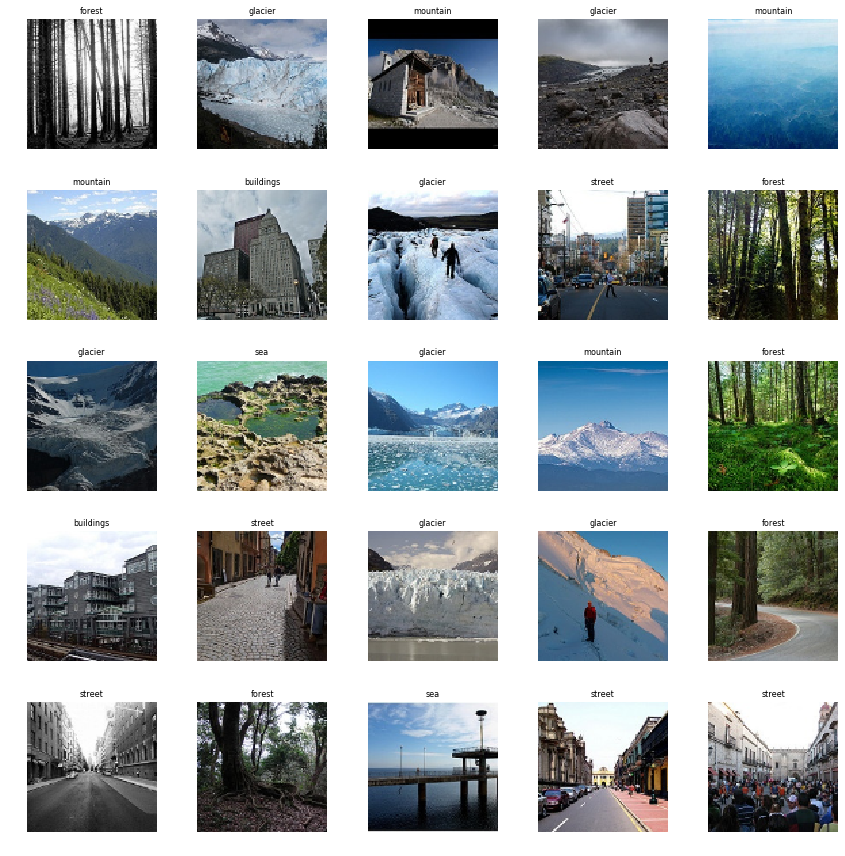

In [6]:
sample_indices = random.sample(range(len(train_images)), 25)
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    img = train_images[idx]
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.title(class_names[train_labels[idx]], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

Further, check the distributions of the categories. The result shows the number are closely balanced.

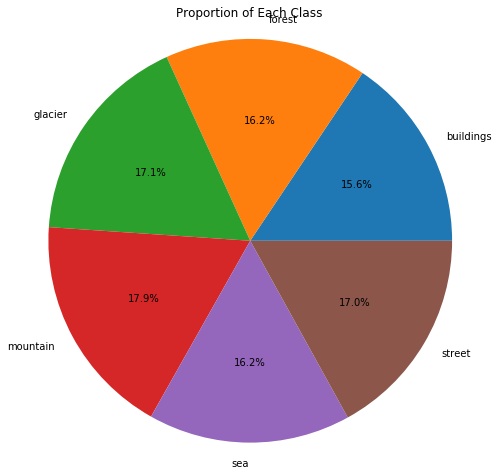

In [8]:
# Pie chart of category distribution
train_class_counts = np.bincount(train_labels)
plt.figure(figsize=(8,8))
plt.pie(train_class_counts, labels=class_names, autopct='%1.1f%%')
plt.title('Proportion of Each Class')
plt.axis('equal')
plt.show()

The final step of the exploration is to check if these images have different characteristics, and a better understanding of the categories can be obtained. Let us first visualize the RGB channel distributions across the categories. From the box plots, it can be seen that:
1. Each categories have characteristic RGB channel distributions.
2. For one category, the RGB channel distributions have relatively the same shape (in mean and spread).
3. The forest category is mostly different from the other categories.


Calculating mean RGB values per class...


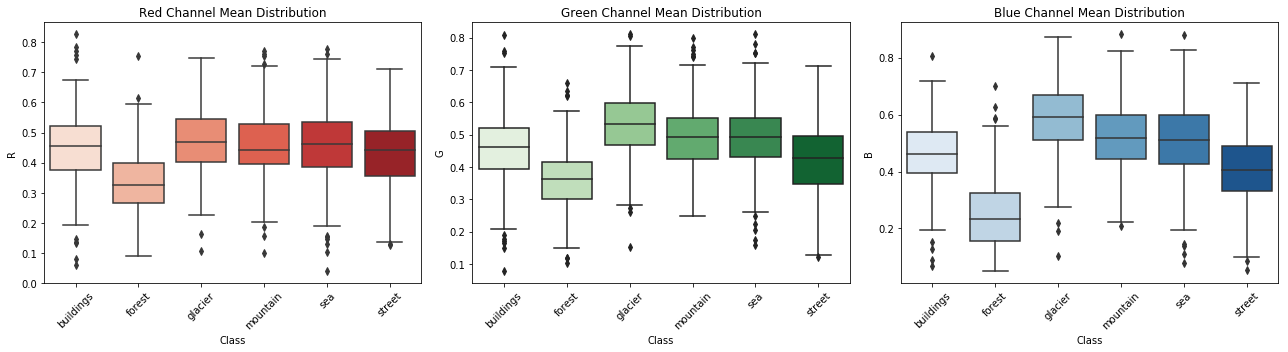

In [9]:
# Sample a few images from each class
samples_per_class = 300  # Number of images per class to sample
all_rgb_means = {cls: [] for cls in class_names}

print("\nCalculating mean RGB values per class...")

for idx, cls in enumerate(class_names):
    indices = np.where(train_labels == idx)[0]
    sampled_indices = np.random.choice(indices, min(samples_per_class, len(indices)), replace=False)
    sampled_images = train_images[sampled_indices]
    
    # Compute mean RGB per image
    for img in sampled_images:
        r_mean = np.mean(img[:,:,0])
        g_mean = np.mean(img[:,:,1])
        b_mean = np.mean(img[:,:,2])
        all_rgb_means[cls].append((r_mean, g_mean, b_mean))

# Convert to DataFrame
import pandas as pd

rgb_data = []
for cls in class_names:
    for rgb in all_rgb_means[cls]:
        rgb_data.append({'Class': cls, 'R': rgb[0], 'G': rgb[1], 'B': rgb[2]})

rgb_df = pd.DataFrame(rgb_data)

# Plot the distributions
plt.figure(figsize=(18,5))

# Red channel
plt.subplot(1, 3, 1)
sns.boxplot(x='Class', y='R', data=rgb_df, palette='Reds')
plt.title('Red Channel Mean Distribution')
plt.xticks(rotation=45)

# Green channel
plt.subplot(1, 3, 2)
sns.boxplot(x='Class', y='G', data=rgb_df, palette='Greens')
plt.title('Green Channel Mean Distribution')
plt.xticks(rotation=45)

# Blue channel
plt.subplot(1, 3, 3)
sns.boxplot(x='Class', y='B', data=rgb_df, palette='Blues')
plt.title('Blue Channel Mean Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Then, let check their difference from 2D representation. It shows the categories form several clusters, and the distance can be interpreted as how different the categories are. For example, the forest and mountain categories have largest distance, suggesting they should be completely different. This observation is consistant with the boxplot above.

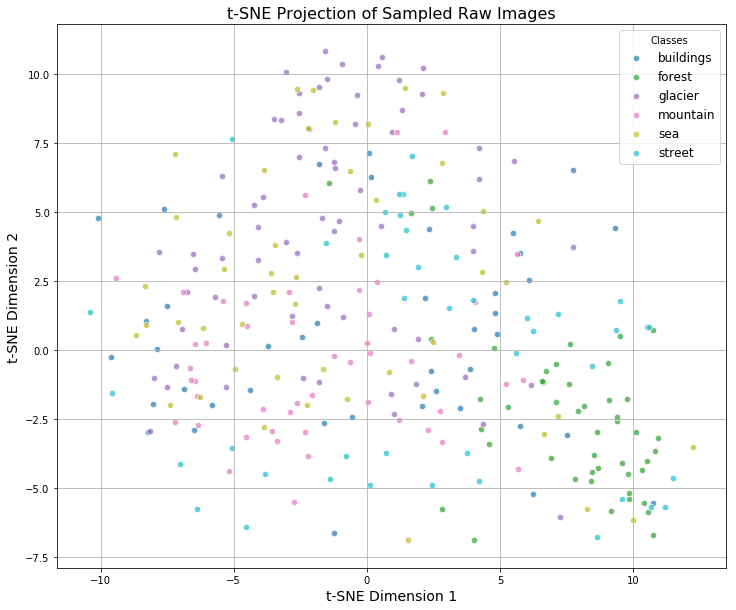

In [23]:
# Subsample a smaller set for faster t-SNE
sample_size = 300  # Requires some time for larger size

if train_images.shape[0] > sample_size:
    sample_idx = np.random.choice(train_images.shape[0], sample_size, replace=False)
    sampled_images = train_images[sample_idx]
    sampled_labels = train_labels[sample_idx]
else:
    sampled_images = train_images
    sampled_labels = train_labels

# Flatten
flattened_sampled_images = sampled_images.reshape(sampled_images.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
sampled_tsne = tsne.fit_transform(flattened_sampled_images)

# Plot
plt.figure(figsize=(12,10))

# Create scatter plot by class
colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))  # Use tab10 color map

for idx, class_name in enumerate(class_names):
    class_points = sampled_tsne[sampled_labels == idx]
    plt.scatter(class_points[:, 0], class_points[:, 1], 
                label=class_name, color=colors[idx], alpha=0.7, edgecolors='w', s=40)

plt.title('t-SNE Projection of Sampled Raw Images', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.legend(title='Classes', loc='best', fontsize=12)
plt.grid(True)
plt.show()

Next, let us check the brightness and colorfulness distribution. The definitions are:

1. Brightness is defined as the mean of the RGB channels:

$$
\text{Brightness} = \frac{R + G + B}{3}
$$

Where:
- $ R $ = Red channel values
- $ G $ = Green channel values
- $ B $ = Blue channel values

2. Colorfulness is defined as the difference between the R-G and G-B channels:

$$
\text{Colorfulness} = \sqrt{\sigma_{rg}^2 + \sigma_{yb}^2} + 0.3 \times \sqrt{\mu_{rg}^2 + \mu_{yb}^2}
$$

Where:
- $ \sigma_{rg} $= Standard deviation of $ R - G $
- $ \sigma_{yb} $ = Standard deviation of $ 0.5(R + G) - B $
- $ \mu_{rg} $ = Mean of $ R - G $
- $ \mu_{yb} $ = Mean of $ 0.5(R + G) - B $

By the obervations,
1. The forest has most different brightness distribution compared to other categories;
2. The colorfulness distributions are more diverse. For example, the mountain categories has the narrowest spread, while the street has the widest spread. This is plausible as streets are decrorated differently. 


Calculating brightness per class...


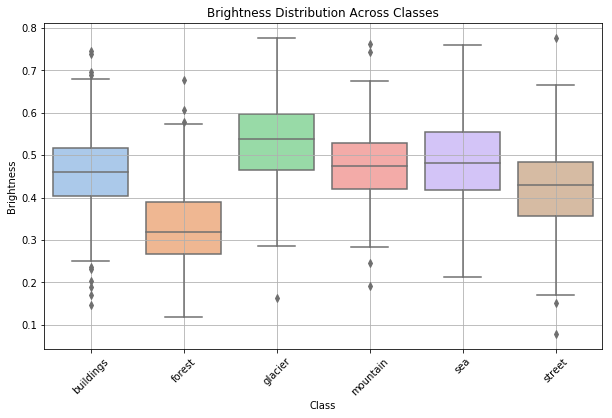

In [11]:
# Sample images (reuse samples if already sampled in RGB analysis)
samples_per_class = 300  # Same sampling number

# Dictionary to store brightness values
all_brightness = {cls: [] for cls in class_names}

print("\nCalculating brightness per class...")

for idx, cls in enumerate(class_names):
    indices = np.where(train_labels == idx)[0]
    sampled_indices = np.random.choice(indices, min(samples_per_class, len(indices)), replace=False)
    sampled_images = train_images[sampled_indices]
    
    # Calculate brightness: mean of R,G,B
    for img in sampled_images:
        brightness = np.mean(img)
        all_brightness[cls].append(brightness)

# Create a DataFrame
brightness_data = []
for cls in class_names:
    for b in all_brightness[cls]:
        brightness_data.append({'Class': cls, 'Brightness': b})

brightness_df = pd.DataFrame(brightness_data)

# Plot the brightness distribution
plt.figure(figsize=(10,6))
sns.boxplot(x='Class', y='Brightness', data=brightness_df, palette='pastel')
plt.title('Brightness Distribution Across Classes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Calculating colorfulness per class...


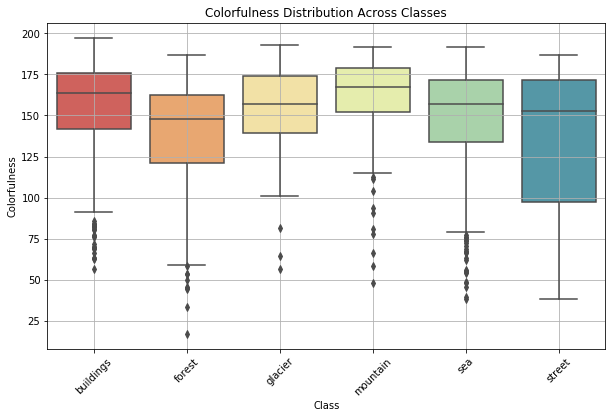

In [12]:
def calculate_colorfulness(img):
    """
    Calculates the 'colorfulness' of an image.
    """
    # Split into R, G, B
    (R, G, B) = cv2.split((img * 255).astype("uint8"))  # Need pixel values between 0-255

    # Compute rg and yb
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)

    # Compute mean and std
    std_rg = np.std(rg)
    std_yb = np.std(yb)
    mean_rg = np.mean(rg)
    mean_yb = np.mean(yb)

    # Final colorfulness score
    colorfulness = np.sqrt(std_rg**2 + std_yb**2) + (0.3 * np.sqrt(mean_rg**2 + mean_yb**2))
    return colorfulness

# Calculate colorfulness
samples_per_class = 300

all_colorfulness = {cls: [] for cls in class_names}

print("\nCalculating colorfulness per class...")

for idx, cls in enumerate(class_names):
    indices = np.where(train_labels == idx)[0]
    sampled_indices = np.random.choice(indices, min(samples_per_class, len(indices)), replace=False)
    sampled_images = train_images[sampled_indices]
    
    for img in sampled_images:
        score = calculate_colorfulness(img)
        all_colorfulness[cls].append(score)

# Create DataFrame
colorfulness_data = []
for cls in class_names:
    for score in all_colorfulness[cls]:
        colorfulness_data.append({'Class': cls, 'Colorfulness': score})

colorfulness_df = pd.DataFrame(colorfulness_data)

# Plot colorfulness
plt.figure(figsize=(10,6))
sns.boxplot(x='Class', y='Colorfulness', data=colorfulness_df, palette='Spectral')
plt.title('Colorfulness Distribution Across Classes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### 2.3 EDA summary

From the exploratory data analysis, the dataset is representative for the categories, and each category has characteristic features.

## 3. Model Building

In this part, a CNN-based model is built for classifying the categories. The steps include:
1. Build and compile the model
2. Train the model
3. Evaluate the performance

 ### 3.1 Build and Compile

In [13]:
# Parameter setting
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.5

# CNN model architecture
model = Sequential()

# Conv Block 1
model.add(Conv2D(first_filters, kernel_size, input_shape=(96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Conv Block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Conv Block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Dense Layers
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# Final Output Layer (MULTI-class)
model.add(Dense(len(class_names), activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
# Compile Model
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # show the summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
__________

### 2.2 Model Training

Let us train the model for 30 epochs with early stopping.

In [15]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history = model.fit(
    train_images, train_labels,
    epochs=30,
    validation_data=(test_images, test_labels),  # 🛠 Corrected here
    batch_size=32,
    callbacks=callbacks
)

Train on 14034 samples, validate on 3000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
14034/14034 [==============================] - 11s 819us/sample - loss: 0.9938 - acc: 0.6318 - val_loss: 1.3102 - val_acc: 0.5643
Epoch 2/30
14034/14034 [==============================] - 9s 677us/sample - loss: 0.6822 - acc: 0.7524 - val_loss: 0.7209 - val_acc: 0.7157
Epoch 3/30
14034/14034 [==============================] - 9s 676us/sample - loss: 0.5881 - acc: 0.7889 - val_loss: 1.6899 - val_acc: 0.5133
Epoch 4/30
14034/14034 [==============================] - 9s 671us/sample - loss: 0.5260 - acc: 0.8110 - val_loss: 1.0094 - val_acc: 0.6423
Epoch 5/30
13952/14034 [============================>.] - ETA: 0s - loss: 0.4695 - acc: 0.8308
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
14034/14034 [==============================] - 9s 669us/sample - loss: 0.4695 - acc: 0.8308 - val_loss: 0.7433 - val_acc: 0.7270
Epoch 6/30
14034/14034 [=============

### 2.3 Evaluation

The evaluation examines accuracy, loss, and prediction performance.

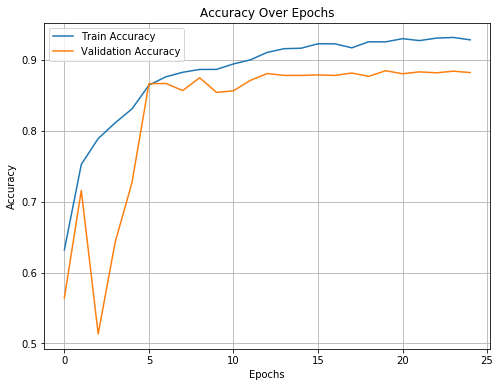

In [16]:
# Train/Test Accuracy Plot
plt.figure(figsize=(8,6))

plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')

plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

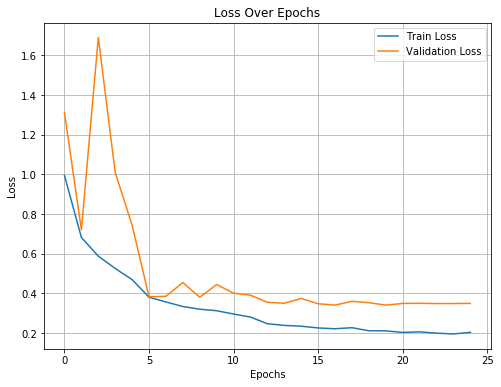

In [17]:
# Loss Plot
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

It shows the training process is converged by the setting. The next is prediction performance.

In [18]:
# Predictions
test_preds = np.argmax(model.predict(test_images), axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(test_labels, test_preds, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

   buildings       0.89      0.84      0.86       437
      forest       0.93      0.99      0.96       474
     glacier       0.85      0.83      0.84       553
    mountain       0.85      0.84      0.85       525
         sea       0.89      0.95      0.92       510
      street       0.90      0.87      0.88       501

   micro avg       0.88      0.88      0.88      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.88      0.88      0.88      3000



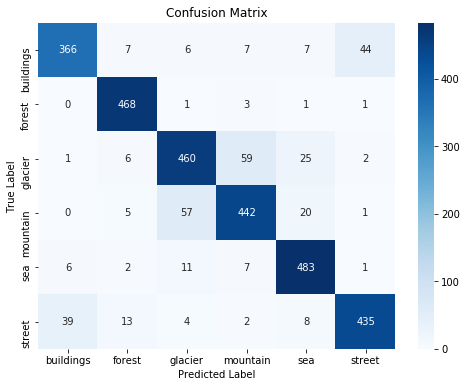

In [19]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

From the confusion matrix, the result shows most misclassifications are in (glacier vs mountain) and (building vs street). Let us go for ROC curves of the categories.

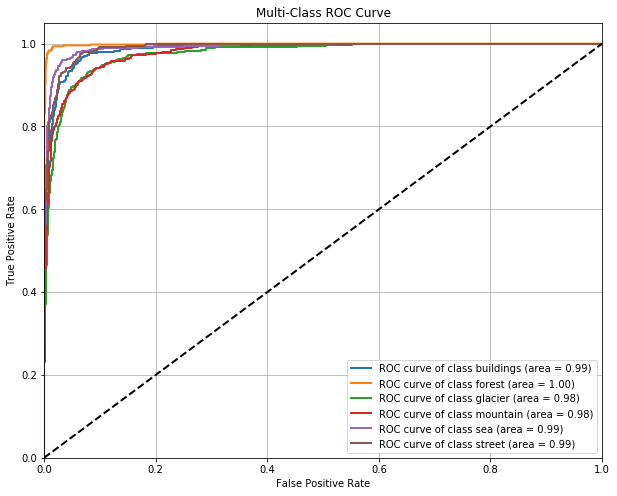

In [21]:
# One-hot encode true labels
test_probs = model.predict(test_images)  # shape (n_samples, n_classes)
test_labels_onehot = label_binarize(test_labels, classes=list(range(len(class_names))))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_onehot[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10,8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

The ROC curves show the model is best at identifying forest. For the two comparison (glacier vs mountain) and (building vs street), their corresponding curves are overlapped.

Finally, let us check the predicted results by the t-SNE visualization. It clearly shows clusters for these categories. But some clusters are very overlapped. For example, the steet and building clusters are overlapped, and this is plausible as urban streets are generally built for connecting blocks of buildings. This is also observed for the sea and mountain clusters.


Running t-SNE on deep features...


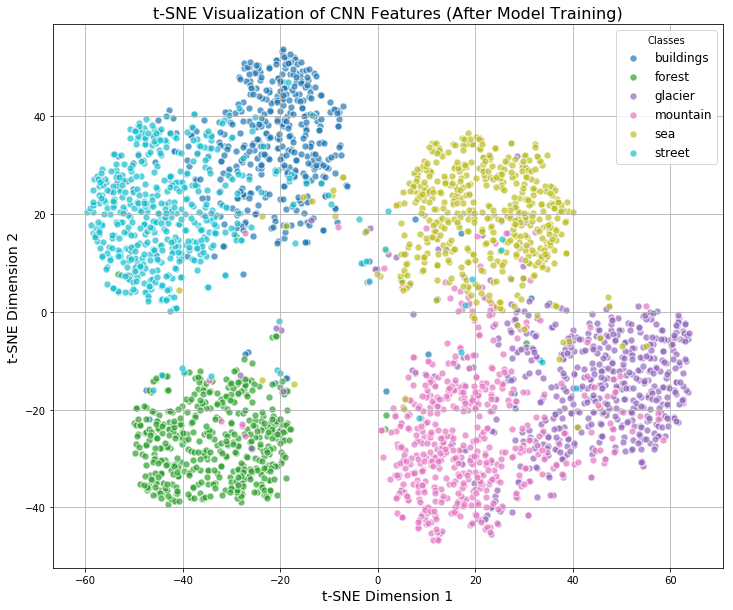

In [22]:
# Extract Features Before Softmax
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
features = feature_extractor.predict(test_images)
features_flat = features.reshape(features.shape[0], -1)

# Apply t-SNE
print("\nRunning t-SNE on deep features...")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_flat)

# Plot t-SNE
plt.figure(figsize=(12,10))

# Scatter plot manually by class
colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

for idx, class_name in enumerate(class_names):
    class_points = features_tsne[test_labels == idx]
    plt.scatter(class_points[:,0], class_points[:,1], 
                color=colors[idx], label=class_name, alpha=0.7, edgecolors='w', s=50)

plt.title('t-SNE Visualization of CNN Features (After Model Training)', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)

# Manual legend
plt.legend(title='Classes', loc='best', fontsize=12)
plt.grid(True)
plt.show()

## 3. Conclusion:

In this final project, a CNN-based classification model is built for identifying photos of five different categoreis. The conclusions are:
1. The five categories have different characteristics in the distributions of RGB, brightness and colorfulness, and the CNN model could capture the characteristics and give a good classification.
2. The model perform well for distinguish forest, sea from others. But the classifications of (buildings vs streets) and (mountains vs glaciers) are less accurate becuase their difference less distinguishable.

Further work could be investigate the information for classifying the close clusters, and improve the model.